In [2]:
import bfrescox
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import inspect
import pandas as pd


In [ ]:
# Name the general template file for your problem
template_name = "12C_4He_inelastic_example.template"

# Name the frescox input file to be generated
frescox_input = "12C_4He_inelastic_example.in"
#Name the frescox output file to be generated (the standard output name)
frescox_output = "12C_4He_inelastic_example.out"

# Define the inelastic scattering system coupling 12C(0+) and 12C(2+)
configuration_template_inelastic = {
          "mass_t" : 12,             # mass of target nucleus
          "charge_t" : 6,            # charge of target nucleus
          "mass_p" : 4,              # mass of projectile
          "charge_p" : 2,            # charge of projectile
          "spin_p" : 0,              # spin of projectile
          "E_lab": 100,              # lab energy in MeV
          "J_tot_min": 0.0,          # minimum  number of total angular momentum (partial waves)
          "J_tot_max": 40.0,         # maximum  number of total angular momentum (partial waves)
          "R_Coulomb": 1.2,          # Coulomb radius parameter in fm
          "I_states": [0.0, 2.0],    # spin states of target nucleus
          "E_states": [0, 4.43],     # excitation energies of target nucleus in MeV
          "Pi_states": [1, 1],       # parities of target nucleus states
          "multipoles": [2],         # multipoles of the couplings included (one can add as many as desired = [0,2,4,...])
          "R_match": 20.0,           # matching radius in fm
          "step_size": 0.05,         # step size in fm
          "reaction_name": "alpha+c12 -> alpha+c12* @ 100 MeV; nuc def"
        }

In [11]:
# Generate the template for your system and set up the frescox input file
bfrescox.generate_inelastic_template(
                template_name, **configuration_template_inelastic
            )

In [ ]:
# Define the deformed model parameters for inelastic scattering, currently using the rigid rotor model in BFrescox
parameters_inelastic =  {
                    "V": 40.0,
                    "r": 1.2,
                    "a": 0.65,
                    "W": 10.0,
                    "rw": 1.2,
                    "aw": 0.5,
                    "Vso": 0,
                    "rso": 1.0,
                    "aso": 0.65,
                    "Wso": 0,
                    "rwso": 1.0,
                    "awso": 0.65,
                    "Vs": 0,
                    "rs": 1.2,
                    "as": 0.5,
                    "Ws": 6,
                    "rws": 1.2,
                    "aws": 0.5,
                    "delta_2": 1.3           # deformation parameter for couplings, e.g., delta_2 for quadrupole
}

In [13]:
# Create the frescox input file by filling in the previously generated template with parameters
cfg = bfrescox.Configuration.from_template(
                    template_name,
                    frescox_input,
                    parameters_inelastic,
                    overwrite=True,
                )

In [14]:
# Run the frescox simulation
bfrescox.run_simulation(cfg, frescox_output, cwd=".", overwrite=True)


In [15]:
# Parse the frescox output file to extract differential cross section results
results_df = bfrescox.parse_differential_xs.absolute_mb_per_sr(
                            frescox_output
                        )

# Can also parse the results as ratio to Rutherford WHEN AVAILABLE
results_df_r2r = bfrescox.parse_differential_xs.ratio_to_rutherford(
                            frescox_output
                        )

In [ ]:
# Note that ration to Rutherford is used only for the elastic channel, 
# The results are parsed in a pandas DataFrame
print(results_df.head())
print(results_df_r2r.head())

               differential_xs_absolute_mb_per_sr
angle_degrees                                    
0.01                                 5.720590e+14
1.00                                 4.908692e+06
2.00                                 2.214236e+05
3.00                                 4.471694e+04
4.00                                 2.355925e+04
               differential_xs_ratio_to_rutherford
angle_degrees                                     
0.01                                      1.000015
1.00                                      0.858043
2.00                                      0.619186
3.00                                      0.632884
4.00                                      1.053451


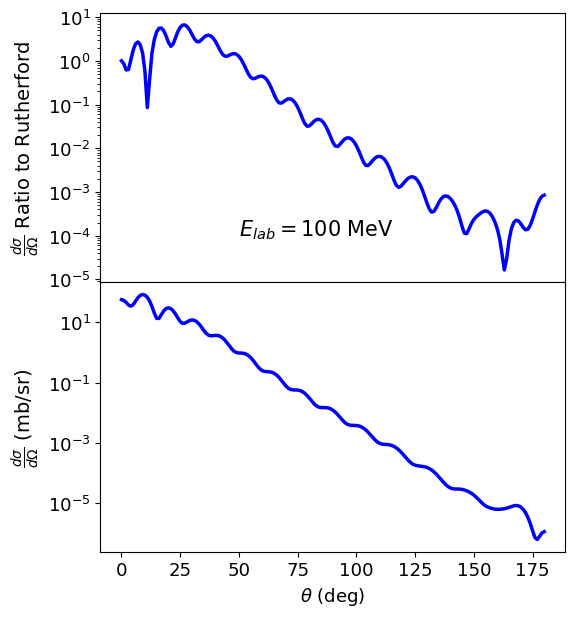

In [34]:
# Plot the results
angles_deg = results_df.index.to_numpy()
diff_xs_mb_per_sr = results_df["differential_xs_absolute_mb_per_sr"].to_numpy()
diff_xs_r2r = results_df_r2r["differential_xs_ratio_to_rutherford"].to_numpy()

angles = angles_deg[:181]
elastic_r2r = diff_xs_r2r
inelastic_mb_sr = diff_xs_mb_per_sr[181:]

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=13)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=11)  # optional minor tick size


ax1.plot(angles, elastic_r2r, lw=2.5, color='blue')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=14)


ax2.plot(angles, inelastic_mb_sr, lw=2.5, color='blue')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=14)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=13)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=15, color='black')


plt.show()

In [35]:
# We can benchmark our results against the results obtained from a standard Frescox installation
# Locate BFrescox test data directory
data_path = (
    Path(inspect.getfile(bfrescox))
    .resolve()
    .parent
    .joinpath("tests", "TestData")
)

# Load the baseline cross section
baseline_file = data_path /  "12C_4He_inelastic_PointA_fort16.pkl"
expected = pd.read_pickle(baseline_file)

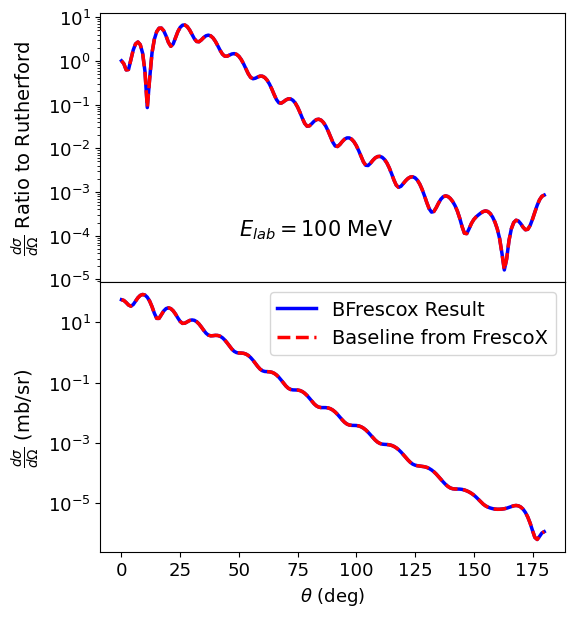

In [46]:
# load the cross section values to benchmark the inelastic and elastic results
elastic_expected = expected["channel_1"]["sigma"].to_numpy()
inelastic_expected = expected["channel_2"]["sigma"].to_numpy()

# Create figure and axes that share all axes
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(6, 7),
    sharex=True, sharey=False
)
plt.subplots_adjust(hspace=0)  # remove gap

# Global font size settings for ticks
for ax in (ax1, ax2):
    ax.tick_params(axis='both', which='major', labelsize=13)  # increase tick font size
    ax.tick_params(axis='both', which='minor', labelsize=11)  # optional minor tick size


ax1.plot(angles, elastic_r2r, lw=2.5, color='blue')
ax1.plot(angles, elastic_expected, lw=2.5, color='red', ls='--')
ax1.set_yscale('log')
ax1.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ Ratio to Rutherford", fontsize=14)


ax2.plot(angles, inelastic_mb_sr, lw=2.5, color='blue', label='BFrescox Result')
ax2.plot(angles, inelastic_expected, lw=2.5, color='red', ls='--', label='Baseline from FrescoX')
ax2.set_yscale('log')
ax2.set_ylabel(r"$\frac{d\sigma}{d\Omega}$ (mb/sr)", fontsize=14)
ax2.set_xlabel(r"$\theta$ (deg)", fontsize=13)
ax1.text(50.0, 1e-4, r"$E_{lab} = 100$ MeV",
        fontsize=15, color='black')

plt.legend(fontsize=14)

plt.show()

In [ ]:
# You could also parse your own results directly from the desired fort file with a function. For example for fort.16,
# we could use a specific parser function (not throughly tested):

def parse_fort16(filename: Path):
    """
    Parse a FrescoX fort.16 output into a dict of DataFrames.
    Each '@sN ... &' block becomes one entry labeled channel_N,
    with all numeric columns and proper names (Theta, sigma, iT11, etc.).

    Parameters:
    filename : Path
        Path to the FrescoX fort.16 output file.

    Returns:
    dict of pd.DataFrame
        Dictionary with keys 'channel_1', 'channel_2', etc., each containing a
        DataFrame of the corresponding data.

    Raises:
    TypeError: If filename is not a string or Path.
    ValueError: If the file does not exist.
    """
    if (not isinstance(filename, str)) and (not isinstance(filename, Path)):
        raise TypeError(f"Invalid filename ({filename})")
    path = Path(filename).resolve()
    if not path.is_file():
        raise ValueError(f"{path} does not exist or is not a file")
    with open(path, "r") as f:
        content = f.read()
    raw_blocks = content.split("&")  # Split into blocks at "&"
    results = {}
    channel_idx = 1
    for block in raw_blocks:
        lines = block.splitlines()
        # Look for header line (columns after '#')
        header = None
        for line in lines:
            if line.strip().startswith("#") and "Theta" in line:
                # Remove "for projectile" etc. and split
                header = line.strip("# ").replace("for projectile", "").split()
                break
        # Collect numeric rows
        rows = []
        for line in lines:
            line = line.strip()
            if not line or line.startswith(("#", "@")):
                continue
            try:
                nums = [float(x) for x in line.split()]
                rows.append(nums)
            except ValueError:
                continue
        if rows:
            df = pd.DataFrame(rows)
            # Assign header if available and lengths match
            if header and len(header) >= df.shape[1]:
                df.columns = header[: df.shape[1]]
            else:
                df.columns = [f"col_{i + 1}" for i in range(df.shape[1])]
            results[f"channel_{channel_idx}"] = df.reset_index(drop=True)
            channel_idx += 1
    return results

In [45]:
results = parse_fort16(Path("fort.16"))
print(results["channel_1"].head())
print(results["channel_2"].head())

   Theta   sigma
0   0.01  1.0000
1   1.00  0.8580
2   2.00  0.6192
3   3.00  0.6329
4   4.00  1.0530
   Theta  sigma
0    0.0  55.26
1    1.0  52.17
2    2.0  44.62
3    3.0  36.89
4    4.0  33.76
